Step 2: Establish a dataset with both stock and sentiment

In [1]:
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import sys 
import os
sys.path.append(os.path.abspath("/Users/13793/Desktop/aas/stock"))
import yfinance as yf
import matplotlib.pyplot as plt

# Add the project root directory to the Python path
import subprocess
result = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], universal_newlines=True)
git_root = result.strip()
sys.path.append(git_root)

from src import processer as processer

c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare Sentiment Data

In [2]:
#Set up for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
MAX_LEN = 50

c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
#BERT processing function setup
def prep(data):
    input_ids = []
    attention_masks = []
    
    for i in data:
        encoding = tokenizer.encode_plus(
                text=i, 
                add_special_tokens=True, 
                padding='max_length', 
                max_length = MAX_LEN, 
                truncation=True, 
                return_tensors="pt", 
                return_attention_mask=True )

        input_ids.append(encoding.get('input_ids'))
        attention_masks.append(encoding.get('attention_mask'))
    
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)
    
    return input_ids, attention_masks

In [4]:
# Define the Bert NLP Classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()
        input_layer = 768
        hidden_layer = 40
        output_layer = 2

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer), 
            nn.ReLU(), 
            nn.Linear(hidden_layer, output_layer))

        if freeze:
            for i in self.bert.parameters():
                i.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        layer = outputs[0][:, 0, :]
        logits = self.classifier(layer)

        return logits

In [5]:
# Check if GPU is available and assign device 
if torch.cuda.is_available():       
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = BertClassifier(freeze=False)
model.load_state_dict(torch.load('stock_sentiment_model.pt'))
model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'stock_sentiment_model.pt'

In [ ]:
# Get the list of stock data to convert
files = os.listdir('data/')

# for each stock files
for x in range(len(files)):
    stock = pd.read_excel('data/'+files[x] + '/export_dashboard_' + files[x], sheet_name='Stream')

    # Assign the ticker name as a column
    stock['Ticker'] = files[x].split('_')[0]
    
    # Convert string date times to datetime
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock['Hour'] = stock['Hour'].apply(lambda t: pd.Timedelta(hours=int(t[:2]), minutes=int(t[3:])))
    stock['Datetime'] = stock['Date'] + stock['Hour']

    # Rename column that holds the tweets content to aligh with previous model
    stock.rename(columns = {'Tweet content':'Text'}, inplace = True)

    # Pre process the tweet content
    stock = processer.Preprocess_Tweets(stock)

    # Remove excess columns
    stock = stock[['Text', 'Favs', 'RTs', 'Tweet Id', 'Ticker', 'Datetime', 'Followers', 'Following']]
    
    # Fill NAs in Favs, RTs, Followers and Following with 0
    stock = stock.fillna(0)

    # Encode processed tweets for Bert NLP model
    stock_inputs, stock_masks = prep(stock['Text'].values)

    batch_size = 16
    stock_data = TensorDataset(stock_inputs, stock_masks)
    stock_sampler = RandomSampler(stock_data)
    stock_dataloader = DataLoader(stock_data, sampler=stock_sampler, batch_size=batch_size)

    model.eval()

    predictions = []
    # Hidden Feature: Use the ratio of Logits to classify if it the pos/neg is strong or weak, discarded due to no significant improvement
    #log1 = []
    #log2 = []
    for batch in stock_dataloader:
        # Get encoded inputs and masks 
        batch_inputs, batch_masks = batch

        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)

        # Predict classes with Bert for given inputs 
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Convert predictions to 0s and 1s
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(preds)
        #log1.append(logits[:,0])
        #log2.append(logits[:,1])
    # Combine all batch predictions
    predictions = torch.cat(predictions).cpu().numpy()
    #log1 = torch.cat(log1).cpu().numpy()
    #log2 = torch.cat(log2).cpu().numpy()

    # Add predictions to stock dataframe
    stock['Sentiment'] = predictions
    #stock['log1'] = log1
    #stock['log2'] = log2
    
    # save predictions as new csv
    stock.to_csv('data/'+files[x] +'/stock_data_sentiment.csv', index=False)
    
    # Show each stock completed 
    print(files[x].split('_')[0], '- completed')

c:\Users\13793\anaconda3\Lib\site-packages\pandas\core\strings\object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)
c:\Users\13793\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


aal - completed
aapl - completed
adbe - completed
adp - completed
adsk - completed
akam - completed
alxn - completed
amat - completed
amgn - completed
amzn - completed
atvi - completed
avgo - completed
bbby - completed
bidu - completed
bmrn - completed
ca - completed
celg - completed
cern - completed
chkp - completed
chtr - completed
cmcsa - completed
cost - completed
csco - completed
csx - completed
ctrp - completed
ctsh - completed
disca - completed
disck - completed
dish - completed
dltr - completed
ea - completed
ebay - completed
endp - completed
esrx - completed
expe - completed
fast - completed
fb - completed
fisv - completed
fox - completed
googl - completed
goog - completed
jd - completed
lbtya - completed
lmca - completed
lmck - completed
lvnta - completed
mar - completed
mdlz - completed
msft - completed
mu - completed
mxim - completed
myl - completed
nclh - completed
nflx - completed
ntes - completed
nvda - completed
nxpi - completed
payx - completed
pcar - completed
pcln - 

,Tweet Id,Ticker,Datetime,Text,Favs,RTs,Followers,Following,Is a RT,Sentiment
0,742609908462440448,fox,2016-06-14 06:49:00,fiduciary management inc wi takes position twe...,0.0,0.0,998.0,0.0,False,0
1,742541587188580352,fox,2016-06-14 02:18:00,,0.0,0.0,4.0,21.0,False,1
2,742506407065354244,fox,2016-06-13 23:58:00,twenty first century foxs fox networks group c...,0.0,0.0,14.0,2.0,False,0
3,742478563400515585,fox,2016-06-13 22:07:00,fox networks longtime cfo mayberry retire read,0.0,0.0,14.0,2.0,False,0
4,742478408072847360,fox,2016-06-13 22:07:00,fox networks names ahuja cfo read,0.0,0.0,14.0,2.0,False,1
...,...,...,...,...,...,...,...,...,...,...
974,714331534879289344,fox,2016-03-28 06:01:00,fox twenty first century fox inc – get news ra...,0.0,0.0,700.0,1.0,False,1
975,714321716164608000,fox,2016-03-28 05:22:00,fox large outflow money witnessed twenty first...,0.0,0.0,866.0,9.0,False,1
976,714316254450855936,fox,2016-03-28 05:00:00,פוקס מצגת לשוק ההון מרץ 2016 fox,0.0,0.0,403.0,2.0,False,1
977,714228580075585536,fox,2016-03-27 23:12:00,fox top stocks day twenty first century fox in...,0.0,0.0,703.0,5.0,False,1


,Tweet Id,Ticker,Datetime,Text,Favs,RTs,Followers,Following,Is a RT,Sentiment,log1,log2
0,743011665663295491,aal,2016-06-15 09:26:00,american airlines group inc aal novo nordisk n...,0.0,0.0,2039.0,108.0,False,1,-1.433798,1.503579
1,742994700563558400,aal,2016-06-15 08:18:00,yesterdays top fallers anglo american aal anto...,0.0,0.0,1792.0,80.0,False,0,2.224170,-1.971137
2,742991573181423618,aal,2016-06-15 08:06:00,saquickideas 5 large cap stocks lowest enterpr...,0.0,0.0,1589.0,1376.0,False,1,-0.467920,0.300075
3,742991250899513345,aal,2016-06-15 08:04:00,jpmorgan chase co reiterates underweight ratin...,0.0,0.0,771.0,8.0,False,1,-2.240959,2.582918
4,742990282380173313,aal,2016-06-15 08:01:00,dal aal 5 large cap stocks lowest enterprise m...,0.0,0.0,788.0,6.0,False,0,1.137528,-0.740291
...,...,...,...,...,...,...,...,...,...,...,...,...
6502,707914551908552705,aal,2016-03-10 13:02:00,u vie 4 flights,1.0,0.0,248.0,156.0,False,1,-2.230855,2.607503
6503,707908040348016640,aal,2016-03-10 12:36:00,new stock pick psnp picking up serious attenti...,0.0,0.0,12543.0,0.0,False,1,-2.363000,2.709309
6504,707907421889495040,aal,2016-03-10 12:34:00,hot new stock alert psnp things really poised ...,0.0,0.0,19713.0,0.0,False,0,2.784819,-2.445995
6505,707906875690512385,aal,2016-03-10 12:32:00,mineral exploration company heating up fast se...,0.0,0.0,12556.0,0.0,False,0,1.067521,-1.100528


Merge with stock data

In [ ]:
stocks = pd.DataFrame()

for x in range(len(files)):
    # Some tickers may be delisted, use try/except to avoid errors if ticker does not exist in yFinance
    try:
        filename = files[x]
        data = pd.read_csv('data/'+filename+'/stock_data_sentiment.csv')
        
        # Convert string time to datetime
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        data['Month'] = data['Datetime'].dt.month
        data['Day'] = data['Datetime'].dt.day
        del data['Datetime']
        del data['Ticker']
        
        # Convert 0 sentiment to -1
        data.loc[data['Sentiment']==0, 'Sentiment'] = -1
        
        # Initialize Weights and Tweet numbers 
        data['Tweets'] = 1
        data['Weight'] = 1

        # Determine the mean and standard deviation of the number of followers a given user has for a given tweet
        # Use rolling average to ensures tweets with less tweets per day are treated equally 
        data['Followers_Mean'] = data['Followers'].rolling(5000, min_periods=1).mean()
        data['Followers_Std'] = data['Followers'].rolling(5000, min_periods=1).std()
        data['Followers_Std'] = data['Followers_Std'].fillna(data['Followers_Std'].values[1])
        # weight tweets from users with higher follower counts more heavily. Calculate based on mean and standard deviation gates
        data.loc[ (data['Followers']>=data['Followers_Mean']) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std'])), 'Weight'] += 0
        data.loc[ (data['Followers']>=(data['Followers_Mean']+data['Followers_Std'])) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std']*2)), 'Weight'] += 1
        data.loc[data['Followers']>=(data['Followers_Mean']+data['Followers_Std']*2), 'Weight'] += 2

        # Same process for retweet
        data['RTs_Mean'] = data['RTs'].rolling(5000, min_periods=1).mean()
        data['RTs_Std'] = data['RTs'].rolling(5000, min_periods=1).std()
        data['RTs_Std'] = data['RTs_Std'].fillna(data['RTs_Std'].values[1])
        data.loc[ (data['RTs']>=data['RTs_Mean']) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std'])), 'Weight'] += 0
        data.loc[ (data['RTs']>=(data['RTs_Mean']+data['RTs_Std'])) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std']*2)), 'Weight'] += 1
        data.loc[data['RTs']>=(data['RTs_Mean']+data['RTs_Std']*2), 'Weight'] += 2
        
        # Same process for Favs
        data['Favs_Mean'] = data['Favs'].rolling(5000, min_periods=1).mean()
        data['Favs_Std'] = data['Favs'].rolling(5000, min_periods=1).std()
        data['Favs_Std'] = data['Favs_Std'].fillna(data['RTs_Std'].values[1])
        data.loc[ (data['Favs']>=data['Favs_Mean']) & (data['Favs'] < (data['Favs_Mean']+data['Favs_Std'])), 'Weight'] += 0
        data.loc[ (data['Favs']>=(data['Favs_Mean']+data['Favs_Std'])) & (data['Favs'] < (data['Favs_Mean']+data['Favs_Std']*2)), 'Weight'] += 1
        data.loc[data['Favs']>=(data['Favs_Mean']+data['Favs_Std']*2), 'Weight'] += 2

        # multiply the sentiment score by the individual weigth
        data['Sentiment_Weighted'] = data['Sentiment']*data['Weight']

        # Group the stock data by months and days
        data = data.groupby(['Month', 'Day']).sum()            
        data['Ticker'] = filename.split('_')[0]
        
        # Reassign date based on index values of month and day
        data['Date'] = pd.to_datetime([ str(x)+'/'+str(y)+'/2016' for (x,y) in data.index.values ])+datetime.timedelta(days=1)
        
        # Drop the index
        data = data.reset_index(drop=True)

        # Divide the sentiment by the total number of tweets 
        data['Sentiment_Weighted'] /= data['Tweets']
        
        # Get the rolling average of the sentiment and tweet volume
        data['Sentiment_mean'] = data['Sentiment_Weighted'].rolling(3, min_periods=1).mean()
        data['Tweets_mean'] = data['Tweets'].rolling(3, min_periods=1).mean()

        # Get the starting date and ending date to extract stock prices 
        start_date = data['Date'].min()
        end_date = data['Date'].max()+datetime.timedelta(days=2)

        # Download stock price data for given range of tweets 
        prices = yf.download(tickers=filename.split('_')[0], start=start_date, end=end_date).reset_index()
        
        # Calculate percent change based on stock price changes, shift to align with the time of tweet (we act after seeing the tweet)
        prices['Percent_Change'] = (prices['Adj Close'].pct_change()*100).shift(-1)
        
        # Bin percent changes by amount lost/gained by stock
        prices['Percent_Change_Bin'] = pd.cut(prices['Percent_Change'], [-100, 0, 2, 100], labels=[0, 1, 2])
        
        # Calculate volume change based on stock price changes (Not used yet)
        prices['Volume_Change'] = (prices['Volume'].pct_change()*100).shift(-1)     

        # Bin volume changes by amount lost/gained by stock
        prices['Volume_Change_Bin'] = pd.cut(prices['Volume_Change'], [-100, 0, 20, 100], labels=[0, 1, 2])       

        # Combine the stock sentiment data and the pricing data 
        data = data.merge(prices, on='Date', how='left')

        # Remove excess columns 
        data = data[['Ticker', 'Date', 'Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean', 'Adj Close', 'Percent_Change', 'Percent_Change_Bin', 'Volume_Change', 'Volume_Change_Bin','Close',"Volume", "Low", "High", "Open"]]
        
        # Drop missing values for days without pricing information 
        data = data.dropna().reset_index(drop=True)
        
        # Save stock sentiment and pricing data to csv
        data.to_csv('data/' + filename + '/stock_data_inputs.csv', index=False)
        
        # Add ticker data to the main data set 
        stocks = pd.concat([stocks, data])
        
        # Print status of ticker 
        print(filename.split('_')[0], '- Completed')
        

    except Exception as e:
        # Print error message
        print(filename.split('_')[0], '-', e)

[*********************100%%**********************]  1 of 1 completed


aal - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


aapl - Completed
adbe - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


adp - Completed
adsk - Completed


[*********************100%%**********************]  1 of 1 completed


akam - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALXN']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


alxn - attempt to get argmax of an empty sequence
amat - Completed


[*********************100%%**********************]  1 of 1 completed


amgn - Completed


[*********************100%%**********************]  1 of 1 completed


amzn - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

atvi - attempt to get argmax of an empty sequence


avgo - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BBBY']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


bbby - attempt to get argmax of an empty sequence
bidu - Completed


[*********************100%%**********************]  1 of 1 completed


bmrn - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CA']: YFChartError("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466136000")


ca - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CELG']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


celg - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CERN']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

cern - attempt to get argmax of an empty sequence
chkp - Completed



[*********************100%%**********************]  1 of 1 completed


chtr - Completed
cmcsa - Completed


[*********************100%%**********************]  1 of 1 completed


cost - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


csco - Completed
csx - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CTRP']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


ctrp - attempt to get argmax of an empty sequence
ctsh - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISCA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


disca - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISCK']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


disck - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISH']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


dish - attempt to get argmax of an empty sequence
dltr - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ea - Completed
ebay - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ENDP']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed


endp - attempt to get argmax of an empty sequence
esrx - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


expe - Completed
fast - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


fb - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FISV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466222400")


fisv - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FOX']: YFChartError("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466136000")


fox - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed


googl - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

goog - Completed



[*********************100%%**********************]  1 of 1 completed


jd - Completed
lbtya - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LMCA']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')


$LMCA: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)
lmca - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LMCK']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LVNTA']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2016-03-29 00:00:00 -> 2016-06-18 00:00:00)')


lmck - attempt to get argmax of an empty sequence
$LVNTA: possibly delisted; No price data found  (1d 2016-03-29 00:00:00 -> 2016-06-18 00:00:00)
lvnta - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


mar - Completed
mdlz - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


msft - Completed
mu - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['MXIM']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


mxim - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['MYL']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


myl - attempt to get argmax of an empty sequence
nclh - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


nflx - Completed
ntes - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


nvda - Completed
nxpi - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


payx - Completed
pcar - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PCLN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$PCLN: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)
pcln - attempt to get argmax of an empty sequence
pypl - Completed



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


qcom - Completed
regn - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

rost - Completed



[*********************100%%**********************]  1 of 1 completed

sbac - Completed
$SNDK: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)




1 Failed download:
['SNDK']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


sndk - attempt to get argmax of an empty sequence
srcl - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


stx - Completed
swks - Completed


[*********************100%%**********************]  1 of 1 completed


tsla - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


txn - Completed
ulta - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VIAB']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


viab - attempt to get argmax of an empty sequence
wdc - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['YHOO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


yhoo - attempt to get argmax of an empty sequence


In [ ]:
display(prices)

,Date,Open,High,Low,Close,Adj Close,Volume


In [ ]:
display(stocks)

,Ticker,Date,Sentiment_Weighted,Sentiment_mean,Tweets,Tweets_mean,Adj Close,Percent_Change,Percent_Change_Bin,Volume_Change,Volume_Change_Bin,Close,Volume,Low,High,Open
0,aal,2016-03-11,0.090909,0.090909,33,33.000000,40.697010,0.282561,1,-19.880733,0,42.470001,5701500.0,41.700001,42.500000,41.889999
1,aal,2016-03-14,0.210526,0.143576,19,25.000000,40.812004,-1.127042,0,-2.683888,0,42.590000,4568000.0,42.119999,42.700001,42.310001
2,aal,2016-03-15,0.200000,0.106539,45,25.000000,40.352036,0.474946,1,7.817069,1,42.110001,4445400.0,41.980000,42.490002,42.299999
3,aal,2016-03-16,0.341176,0.250568,85,49.666667,40.543686,-0.496327,0,24.363120,2,42.310001,4792900.0,41.590000,42.430000,41.810001
4,aal,2016-03-18,0.081967,0.230479,61,62.333333,41.626507,0.069079,1,-65.397934,0,43.439999,13746000.0,41.750000,43.529999,42.310001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,wdc,2016-06-10,0.600000,0.614035,35,58.333333,40.854412,-1.216640,0,-21.877925,0,46.849998,5876700.0,46.430000,47.759998,47.689999
50,wdc,2016-06-13,0.594595,0.572072,37,30.000000,40.357361,0.259286,1,19.039425,1,46.279999,4591000.0,46.250000,47.490002,46.650002
51,wdc,2016-06-14,0.710526,0.601707,38,30.333333,40.462002,-0.301729,0,-35.902362,0,46.400002,5465100.0,45.459999,47.430000,46.250000
52,wdc,2016-06-15,0.333333,0.546151,30,35.000000,40.339916,0.345877,1,-6.151870,0,46.259998,3503000.0,46.009998,47.020000,46.400002


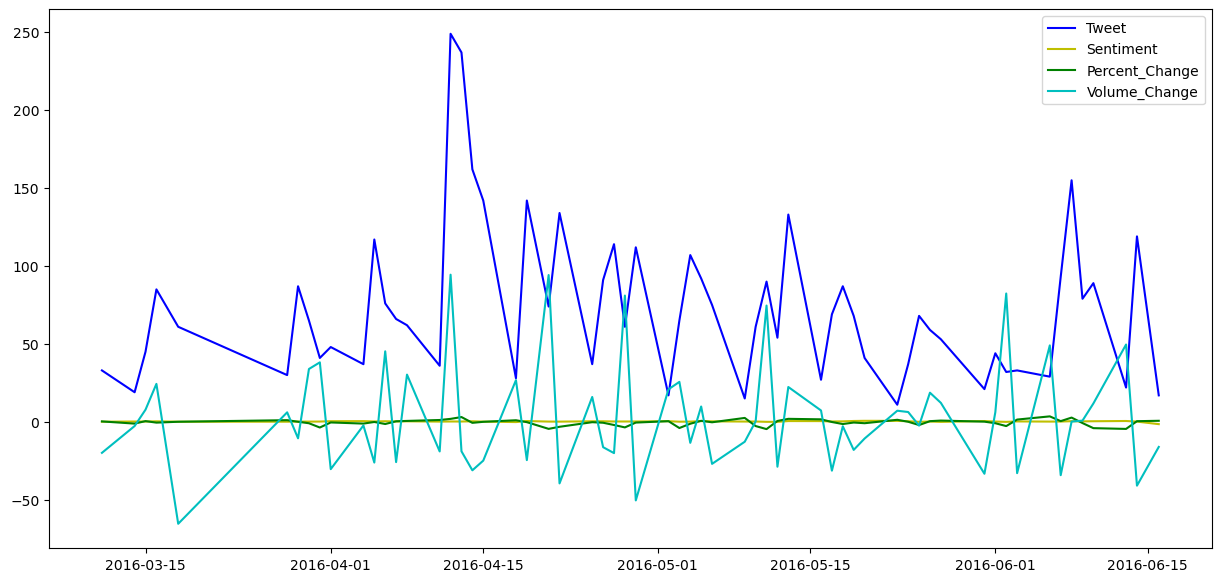

In [ ]:
#Example on how those factors related
aal = stocks[stocks['Ticker']=='aal']
dates = aal['Date'].sort_values().unique()
plt.figure(figsize=(15,7))
plt.plot(dates, aal['Tweets'], c='b', label='Tweet')
plt.plot(dates, aal['Sentiment_Weighted'], c='y', label='Sentiment')
plt.plot(dates, aal['Percent_Change'], c='g', label='Percent_Change')
plt.plot(dates, aal['Volume_Change'], c='c', label='Volume_Change')
plt.legend()
plt.show()

In [ ]:
stocks.to_csv('Stock_with_sentiment.csv', index=False)

In [ ]:
display(aal)

,Ticker,Date,Sentiment_Weighted,Sentiment_mean,Tweets,Tweets_mean,Adj Close,Percent_Change,Percent_Change_Bin,Volume_Change,Volume_Change_Bin,Close,Volume,Low,High,Open
0,aal,2016-03-11,0.090909,0.090909,33,33.000000,40.697010,0.282561,1,-19.880733,0,42.470001,5701500.0,41.700001,42.500000,41.889999
1,aal,2016-03-14,0.210526,0.143576,19,25.000000,40.812004,-1.127042,0,-2.683888,0,42.590000,4568000.0,42.119999,42.700001,42.310001
2,aal,2016-03-15,0.200000,0.106539,45,25.000000,40.352036,0.474946,1,7.817069,1,42.110001,4445400.0,41.980000,42.490002,42.299999
3,aal,2016-03-16,0.341176,0.250568,85,49.666667,40.543686,-0.496327,0,24.363120,2,42.310001,4792900.0,41.590000,42.430000,41.810001
4,aal,2016-03-18,0.081967,0.230479,61,62.333333,41.626507,0.069079,1,-65.397934,0,43.439999,13746000.0,41.750000,43.529999,42.310001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,aal,2016-06-09,0.316456,0.317672,79,109.000000,32.098179,-0.778438,0,0.781603,1,33.400002,8188300.0,32.250000,33.580002,32.250000
57,aal,2016-06-10,0.393258,0.380657,89,107.666667,31.848314,-4.043458,0,11.794288,1,33.139999,8252300.0,32.639999,33.480000,32.799999
58,aal,2016-06-13,0.545455,0.216112,22,74.000000,30.560541,-4.528288,0,49.615201,2,31.799999,9225600.0,31.639999,32.990002,32.990002
59,aal,2016-06-14,0.159664,0.149018,119,57.333333,29.176672,0.428183,1,-40.937774,0,30.360001,13802900.0,30.020000,31.969999,31.809999
